In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':25});
plt.rcParams.update({'axes.linewidth':1.5})
plt.rc('lines',linewidth=3);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
from scipy.signal import savgol_filter as savgol
import seaborn as sns
import scanpy as sc

from read_PR_data import PR_2_dicts # PR stands for plate reader 

In [8]:
def read_pr_data_and_metadata(datafile, metadatafile, metadatasubfile, nRows=8, nCols=12, sampling_rate=5):
    '''
    Inputs
    ------
    
        datafile : str
            The path to the file containing the plate reader data (in tab delimited format)
    
        metadatafile : str, 
            The path to the metadata file (as comma separated values)
    
        metadatasubfile : str
            The sheet name in the metadatafile
            
        nRows : int
            Number of rows measured in the plate reader experiment
        
        nCols : int
            Number of columns measured in the plate reader experiment
            
        sampling_rate : float or int
            Interval between data samples from the plate reader experiment
        
    Returns 
    -------
    
        adata : Anndata object
            adata.X contains the optical density as a numpy array 
            adata.obsm['fl'] contains the fluorescence as a numpy array 
            adata.obsm['fln'] contains the OD normalized fluorescence as a numpy array 
            adata.obs contains the metadata in a pandas dataframe
            adata.uns['t'] contains the time span in hours
    '''
    
    data, nReads = PR_2_dicts(datafile,nRows,nCols) # get the OD and fluorescence measurements in a dictionary called data
    od, fl = data # unpack
    tspan = np.linspace(0,nReads*sampling_rate,nReads)/60 # represent time in hours
    
    # get metadata 
    xls = pd.ExcelFile(metadatafile)
    obs = pd.read_excel(xls,metadatasubfile,index_col=0)
    
    # remove keys from data dictionaries if not present in metadata
    keys_to_remove = list( set(list(od.keys())) - set(obs.index.tolist()) )
    for key in keys_to_remove: 
        del od[key]
        del fl[key]

    # OD normalize the fluorescence measurements
    fln = {}
    for key in fl:
        fln[key] = fl[key]/od[key] 
    
    # put the data in anndata format for easy parsing of both data modalities and metadata
    adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
    adata.obsm['fln'] = pd.DataFrame(fln).T # normalized fluorescence
    adata.obsm['fl'] = pd.DataFrame(fl).T # fluorescence
    adata.uns['t'] = tspan # time span
    
    return adata

# Antibiotic screens

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS09335 -- lag phase, 8 µg/mL ampicillin, 100 µM SD8

In [9]:
dataFile = 'adp1_antibiotic_10.12.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.12'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_32668\3036002018.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
C:\Users\linus\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


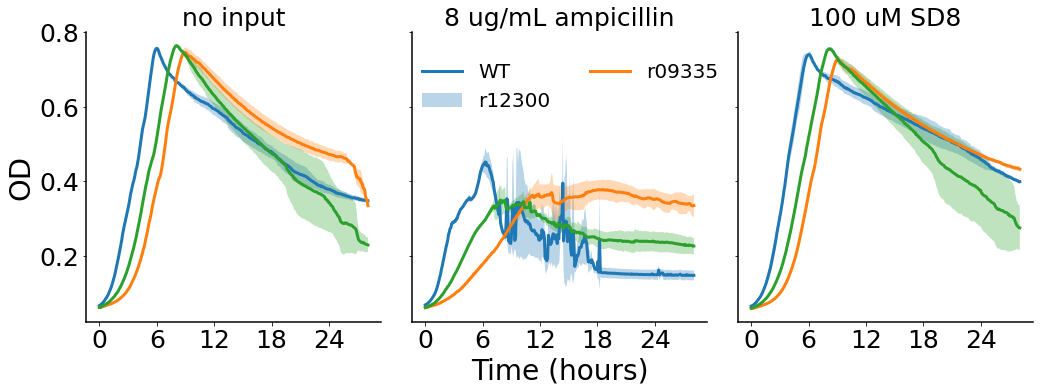

In [10]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X,axis=0)
    std = np.std(bdata.X,axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin':
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'SD8':
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/antibiotic-resistance/results/OD_10.12.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### A. baylyi ADP1 WT, ACIAD_RS12300, and ACIAD_RS14095 -- log phase, 8 µg/mL ampicillin, 16 µg/mL ampicillin

In [11]:
dataFile = 'adp1_antibiotic_10.16.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.16'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_32668\3036002018.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
C:\Users\linus\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


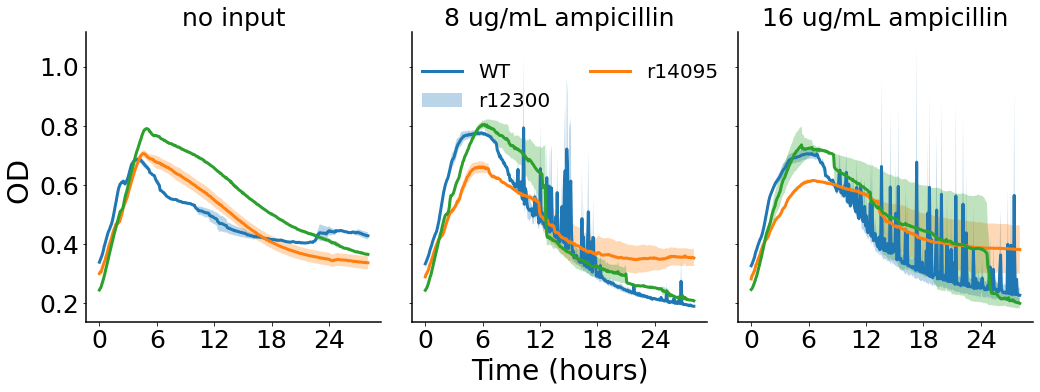

In [12]:
# take mean of each (strain, compound, concentration) and plot 
savefig = False
fig, ax = plt.subplots(1,3,figsize = (15, 6),sharex=True,sharey=True)
ax = ax.reshape(-1)
alpha = 0.3
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=range(0,30,6), xticklabels=range(0,30,6))
for cond in adata.obs.condition.unique():
    bdata = adata[adata.obs.condition.isin([cond])].copy()
    mean = np.mean(bdata.X[0:2],axis=0)
    std = np.std(bdata.X[0:2],axis=0)
    if bdata.obs.compound[0] == 'none':
        ax[0].plot(adata.uns['t'],mean)
        ax[0].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 8:
        ax[1].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[1].plot(adata.uns['t'],mean)
        ax[1].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
    elif bdata.obs.compound[0] == 'ampicillin' and bdata.obs.concentration[0] == 16:
        ax[2].set_title(f'{bdata.obs.concentration[0]} {bdata.obs.concentration_unit[0]} {bdata.obs.compound[0]}',fontsize=25)
        ax[2].plot(adata.uns['t'],mean)
        ax[2].fill_between(adata.uns['t'],mean-std,mean+std,alpha=alpha)
ax[0].set_title('no input',fontsize=25)
ax[1].set_xlabel('Time (hours)',fontsize=28)
ax[0].set_ylabel('OD ',fontsize=29)
fig.legend(adata.obs.strain.unique(),frameon=False,fontsize=20,bbox_to_anchor=(0.7,0.85),ncol=2)
plt.tight_layout()
if savefig: 
    plt.savefig('/Users/aqib/desktop/bccl/adp1-adaptation/results/OD_10.16.pdf',transparent=True,bbox_inches='tight',
               dpi=300);
plt.show()

### ADP1 antibiotic 10.19

In [19]:
dataFile = 'adp1_antibiotic_10.19.txt'
metadataFile = 'plate_layouts.xlsx'
metadatasubFile = 'adp1_antibiotic_10.18'
numRows = 8
numCols = 12
sampling_rate = 5 # minutes
adata = read_pr_data_and_metadata(dataFile,metadataFile,metadatasubFile,nRows=numRows,nCols=numCols,sampling_rate=sampling_rate)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_32668\3036002018.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=pd.DataFrame(od).T, obs=obs) # optical density in adata.X
C:\Users\linus\anaconda3\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
adata.obsm['fln'].iloc[0]


0      41.666667
1      54.054054
2      40.000000
3      89.743590
4      62.500000
         ...    
332    25.862069
333    18.965517
334    20.797227
335    17.301038
336    20.797227
Name: B4, Length: 337, dtype: float64

In [21]:
adata.obs['strain'].unique()

array(['WT', 'pBWB162'], dtype=object)

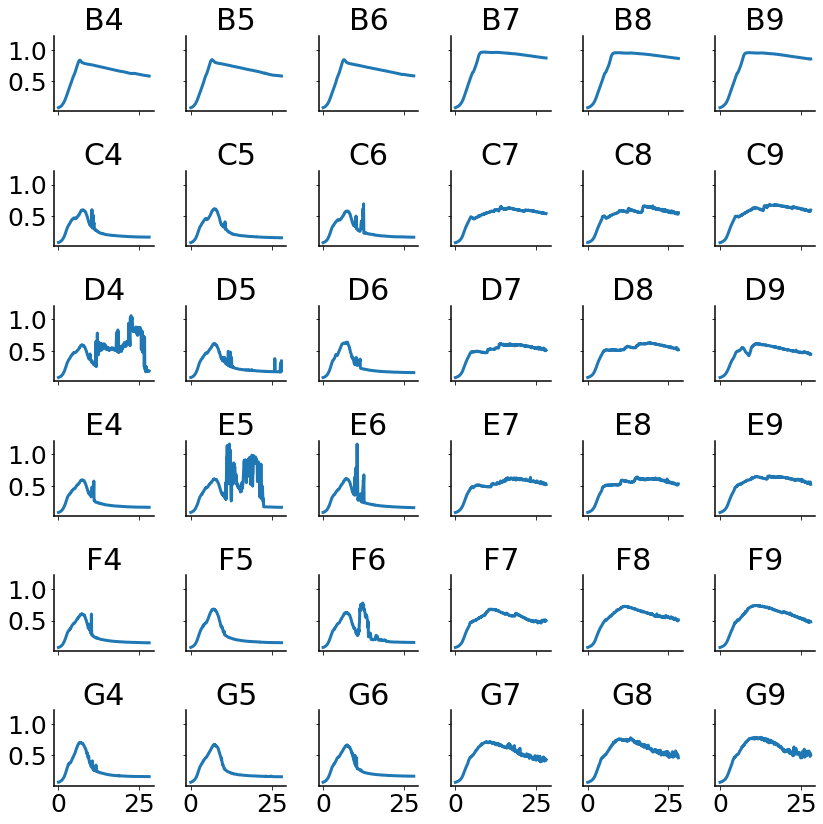

In [42]:
fig, axs = plt.subplots(6,6,figsize=(12,12),sharex=True,sharey=True)
for ii, ax in enumerate(axs.reshape(-1)):
    ax.set_title(adata.obs.index[ii])
    ax.plot(adata.uns['t'],adata.X[ii])
plt.tight_layout()
plt.show()

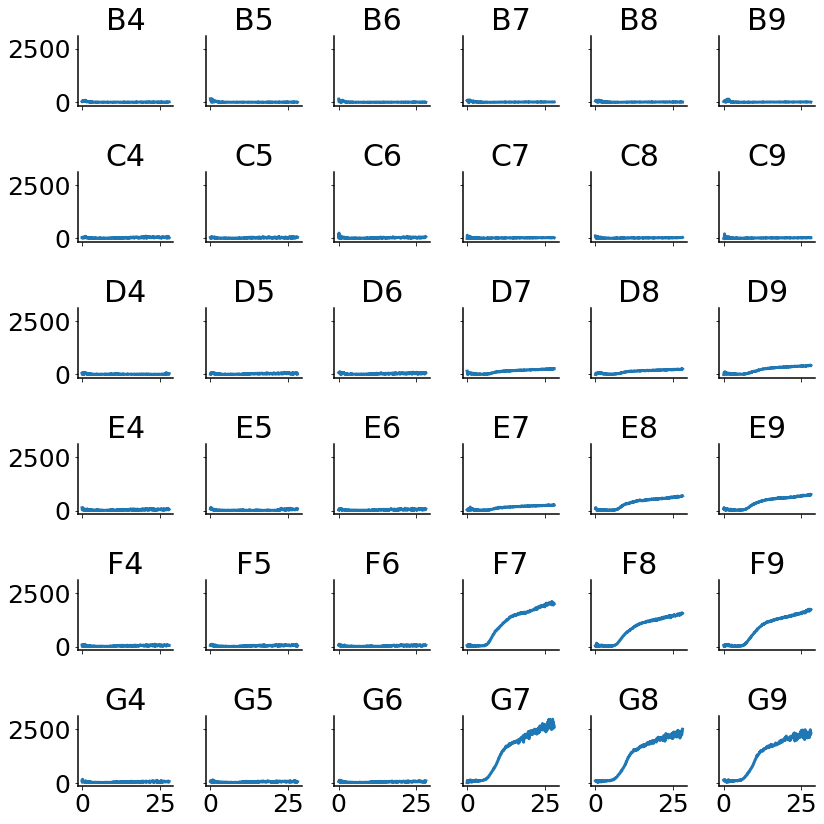

In [41]:
fig, axs = plt.subplots(6,6,figsize=(12,12),sharex=True,sharey=True)
for ii, ax in enumerate(axs.reshape(-1)):
    ax.set_title(adata.obs.index[ii])
    ax.plot(adata.uns['t'],adata.obsm['fln'].iloc[ii])
plt.tight_layout()
plt.show()

In [51]:
OD = savgol(adata.X, axis=1, window_length= 11, polyorder= 1)
odfinal = OD[:, -1]
#np.mean()
fln = savgol(adata.obsm['fln'], axis=1, window_length= 11, polyorder= 1)
flnsum = np.sum(fln, axis=1)

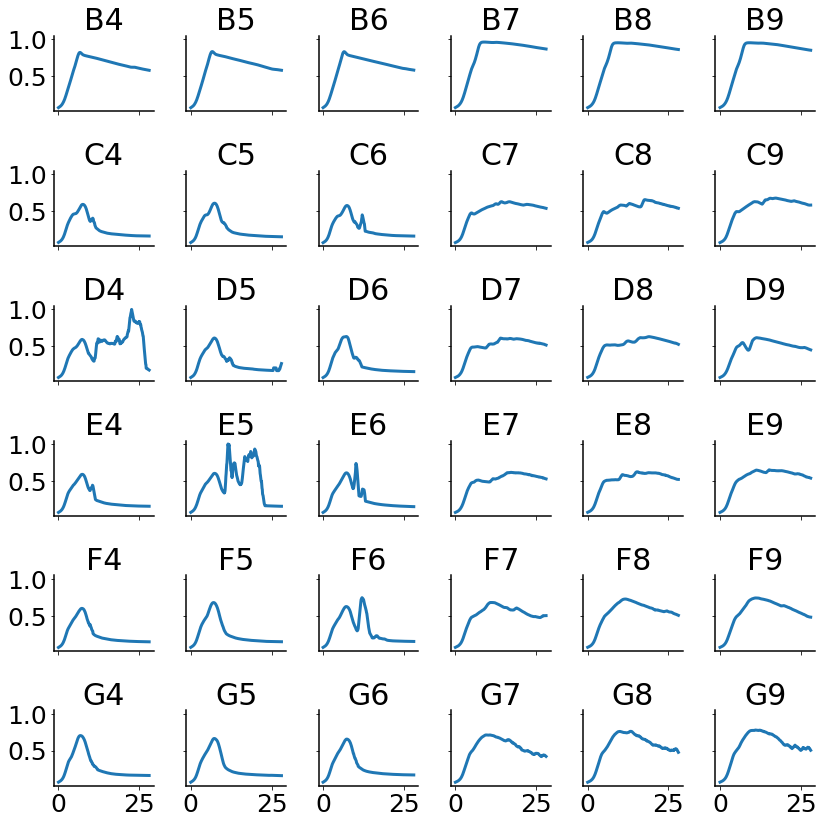

In [52]:
fig, axs = plt.subplots(6,6,figsize=(12,12),sharex=True,sharey=True)
for ii, ax in enumerate(axs.reshape(-1)):
    ax.set_title(adata.obs.index[ii])
    ax.plot(adata.uns['t'],OD[ii])
plt.tight_layout()
plt.show()

<AxesSubplot:>

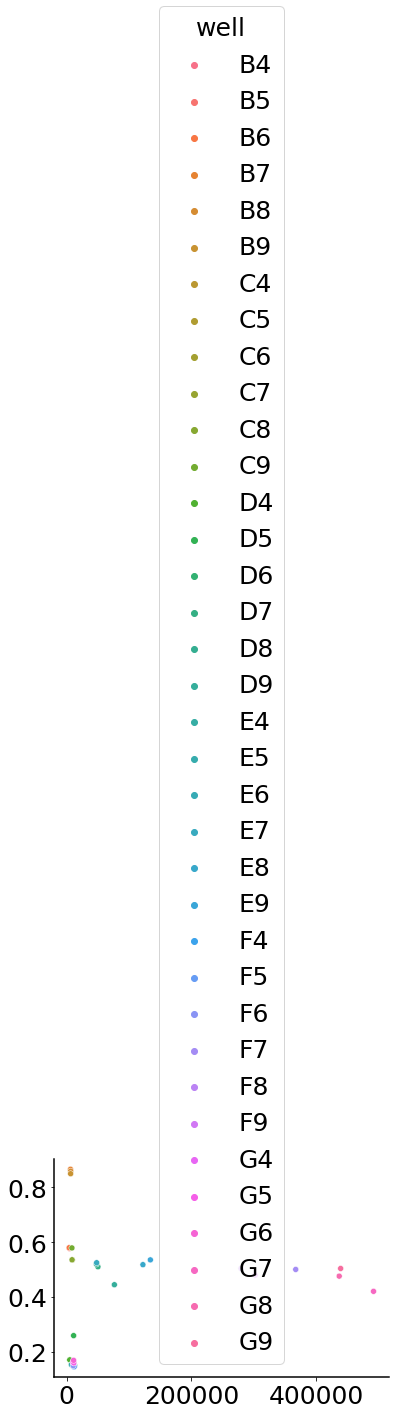

In [54]:
sns.scatterplot(x=flnsum, y=odfinal, hue=adata.obs.index)

In [ ]:
#mean of each 3, delta OD, sum of flr